In [1]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import utils

warnings.filterwarnings('ignore')

/home/cognam/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
model_col = joblib.load('data/August/model_columns.pkl')
print(type(model_col), model_col)
model_col.remove('Sending Method Type_IV')
# model_col.remove('Amount_transformed')

# if True:
#     model_col.remove('Tx count for remitter_transformed')
#     model_col.remove('Tx count for beneficiary_transformed')
#     model_col.remove('Days count from the last tx_transformed')


idology_features = ['QUALIFIERS_NEW=Address Does Not Match', 'QUALIFIERS_NEW=Address Longevity Alert',
                    'QUALIFIERS_NEW=Address Velocity Alert', 'QUALIFIERS_NEW=Age Above Maximum',
                    'QUALIFIERS_NEW=Data Strength Alert', 'QUALIFIERS_NEW=Low Risk Score',
                    'QUALIFIERS_NEW=Single Address in File', 'QUALIFIERS_NEW=Street Name Does Not Match',
                    'QUALIFIERS_NEW=Street Number Does Not Match']

model_col.extend(idology_features)

'''
ACH Transactions
'''

train_file = pd.read_excel('data/Sept/IdologyFeat/Transformed-ACH-1-2017_6-2019.xlsx')



<class 'list'> ['FINAL_RESULT_EMAILAGE=SOFT FAIL', 'Amount_transformed', 'Payer_IV', 'Age_transformed', 'IP_RISK_LEVEL_ID=1.0', 'IP_RISK_LEVEL_ID=2.0', 'DOMAIN_NAME_IV', 'FINAL_RESULT_EMAILAGE=PASS', 'IP_RISK_LEVEL_ID=3.0', 'Origin State_IV', 'IP_USER_TYPE_IV', 'FINAL_RESULT_EMAILAGE=FAIL', 'IP_RISK_LEVEL_ID=4.0', 'Sending Method Type_IV', 'Tx count for remitter_transformed', 'Joining Time_transformed', 'User Level_IV', 'Days count from the last tx_transformed', 'IP_RISK_LEVEL_ID=5.0', 'Beneficiary State_IV', 'Tx count for beneficiary_transformed', 'IP_RISK_LEVEL_ID=6.0']


In [4]:
x_train = train_file[model_col]
y_train = train_file['Label']
print(f'Train shape = {x_train.shape}')
# print(data_train.isna().sum())

Train shape = (2329, 30)


In [5]:
tuned_parameters = [{'max_depth': [5, 6, 7, 8, 9, 10]}]

rf_clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5, scoring='recall_macro')
rf_clf.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [6]:
test_file = pd.read_excel('data/Sept/IdologyFeat/Transformed-Aug19ACH.xlsx')
test_file = test_file[test_file['Tx date and time'] > '2019-06-30']

print('Test File', test_file.shape)

ach_x = test_file[model_col]
ach_y = test_file['Label']

Test File (156, 110)


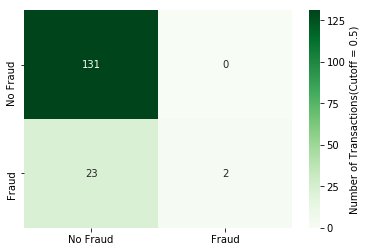

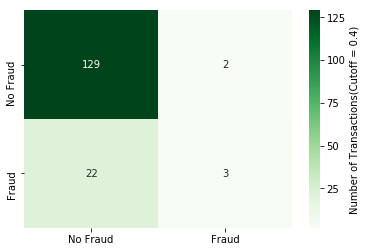

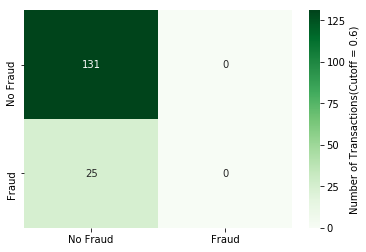

In [7]:
y_pred = rf_clf.predict(ach_x)
y_prob = rf_clf.predict_proba(ach_x)


conf = confusion_matrix(ach_y, y_pred)
sns.heatmap(conf, annot=True, cmap="Greens", fmt='g', cbar_kws={'label': 'Number of Transactions(Cutoff = 0.5)'},
            xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.show()

data_test = test_file.copy()
data_test['y_pred'] = y_pred
data_test['y_prob'] = y_prob[:, 1]
data_test['Label'] = ach_y

test_ach = data_test[data_test['Sending Method Type'].isin(['BANK ACCOUNT'])]
test_ach['y_pred_60'] = (test_ach['y_prob'] > 0.60).astype(int)
test_ach['y_pred_40'] = (test_ach['y_prob'] > 0.40).astype(int)


conf = confusion_matrix(test_ach['Label'], test_ach['y_pred_40'])
sns.heatmap(conf, annot=True, cmap="Greens", fmt='g', cbar_kws={'label': 'Number of Transactions(Cutoff = 0.4)'},
            xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.show()


conf = confusion_matrix(test_ach['Label'], test_ach['y_pred_60'])
sns.heatmap(conf, annot=True, cmap="Greens", fmt='g', cbar_kws={'label': 'Number of Transactions(Cutoff = 0.6)'},
            xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.show()